<a href="https://colab.research.google.com/github/dheerajreddy3108/Twitter-Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/My Drive/')
os.getcwd()

'/content/gdrive/My Drive'

In [46]:
#importing  Basic Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
#importing NLTK related Libraries
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud, STOPWORDS
from nltk import word_tokenize
from gensim.models import Word2Vec


#importing Tensorflow Libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Embedding
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [4]:
#changing the settings to see complete text in the output box of each cell

pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [5]:
#setting the path for the training and testing data

path = '/content/gdrive/My Drive/sentiment_data'
files = os.listdir(path)
print(files)

['testdata.csv', 'training.csv', 'temp.gsheet', 'temp.csv', 'word2vec.model']


In [6]:
#adding a header to the csv file 

csv_cols = ['target_label', 'ids','date','flag','user','tweet']
df_train = pd.read_csv(os.path.join(path, 'training.csv'),encoding='ISO-8859-1', names = csv_cols)

df_train.dropna(inplace=True)
print(df_train.shape)

(1600000, 6)


In [7]:
#visualizing first first rows of training csv file
df_train.head(5)

,target_label,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [8]:
#finding the number of categories in the data

unique_labels = df_train['target_label'].unique()
#converting to a list
unique_labels_list = unique_labels.tolist()
print(unique_labels_list)

[0, 4]


In [9]:
#finding number of data samples for each label
print(df_train['target_label'].value_counts())

0    800000
4    800000
Name: target_label, dtype: int64


In [10]:
#reading test csv file and visualizing first 5 rows 

df_test = pd.read_csv(os.path.join(path, 'testdata.csv'),encoding='ISO-8859-1', names = csv_cols)
df_test.head(5)

,target_label,ids,date,flag,user,tweet
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs is good read.
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :)


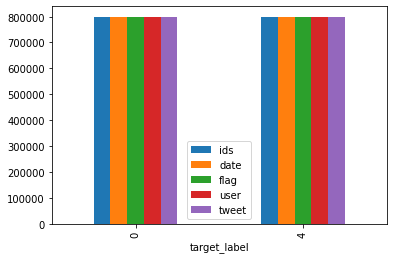

In [11]:
#plot to see the number of tweets per label

df_train.groupby('target_label').count().plot(kind='bar')


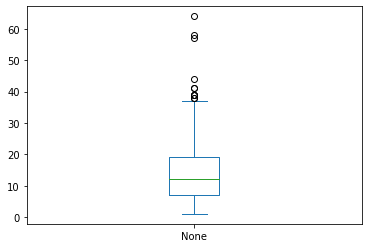

In [12]:
#plot to find the distribution of tweet length

tweet_length = pd.Series([len(tweet.split()) for tweet in df_train['tweet']])
tweet_length.plot(kind = 'box')

In [13]:
#Data Visualization

def data_visualization(target_label,color):
  fig = plt.figure(figsize=(14,7))
  df_train['length'] = df_train.tweet.str.split().apply(len)
  ax1 = fig.add_subplot(122)
  sns.histplot(df_train[df_train['target_label']==target_label]['length'], ax=ax1,color=color)
  describe = df_train.length[df_train.target_label==0].describe().to_frame().round(2)

  ax2 = fig.add_subplot(121)
  ax2.axis('off')
  font_size = 14
  bbox = [0, 0, 1, 1]
  table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
  table.set_fontsize(font_size)
  fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

  plt.show()



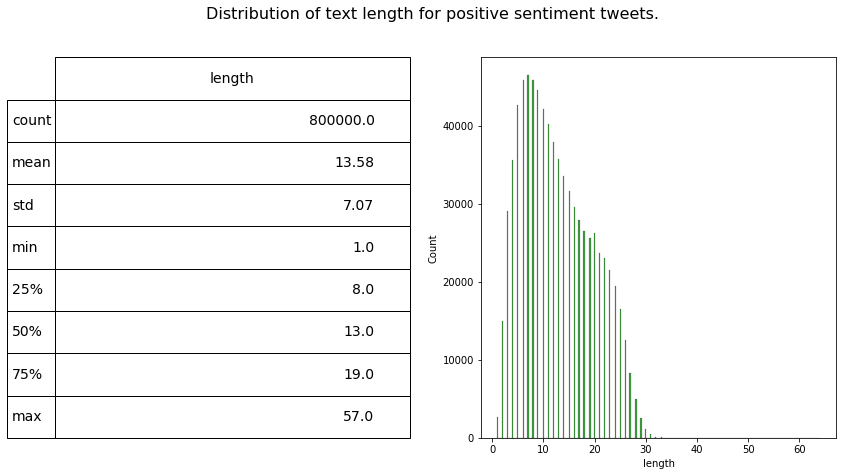

In [14]:
#Visualization with label 4
pos_viz = data_visualization(target_label=4,color = 'green')

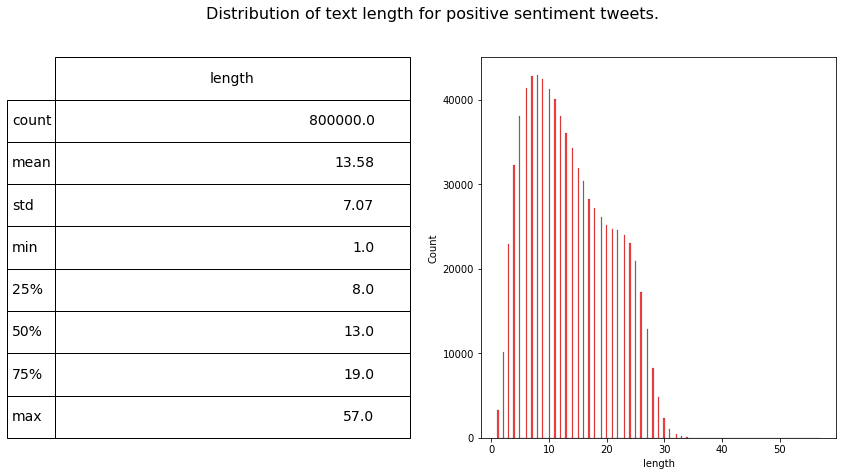

In [15]:
#visualization with label 0
pos_viz = data_visualization(target_label=0,color = 'red')

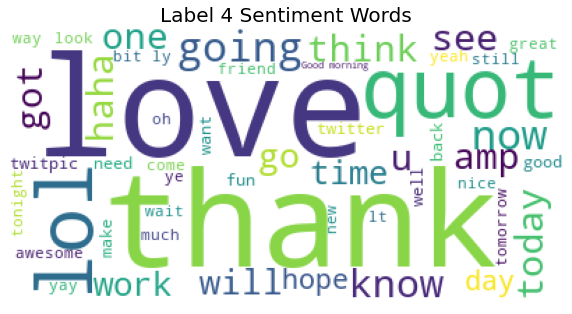

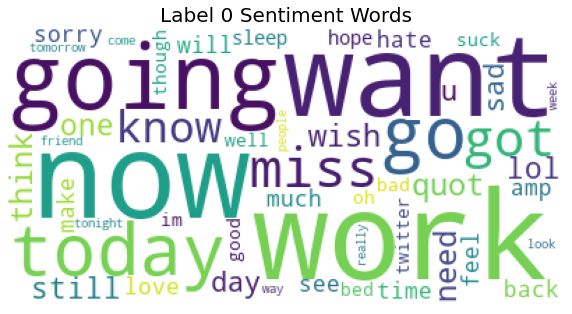

In [16]:

def wordcount_gen(df, target_label):

    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df_train[df_train.target_label==target_label]['tweet']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('Label {} Sentiment Words'.format(target_label), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(df_train, 4)
     
# Negative tweet words
wordcount_gen(df_train, 0)
     
     

In [17]:
#removes hyperlink

def remove_links(text):
  text = str(text).lower()
  url_chars = 'https?:\S+|http?:\S+'
  text = re.sub(url_chars, ' ', text).strip()
  return text
  
#removes special charecters 
def remove_spcl_chars(text):
  text = str(text).lower()
  spcl_chars = '[^A-Za-z0-9]+'
  text = re.sub(spcl_chars,' ', text).strip()
  return text


In [18]:
#installing contractions library 

!pip install contractions
import contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 4.8 MB/s 
     |████████████████████████████████| 106 kB 53.7 MB/s 


In [19]:
#applying expand contractions

df_train.tweet = df_train.tweet.apply(lambda x : contractions.fix(x))

In [20]:
#can't is changed to cannot after expanding contractions

print(df_train.iloc[1].values)


[0 1467810672 'Mon Apr 06 22:19:49 PDT 2009' 'NO_QUERY' 'scotthamilton'
 'is upset that he cannot update his Facebook by texting it... and might cry as a result  School today also. Blah!'
 21]


In [21]:
#applying function 'remove_links' and 'remove_spcl_chars'

df_train.tweet = df_train.tweet.apply(lambda x: remove_links(x))
df_train.tweet = df_train.tweet.apply(lambda x: remove_spcl_chars(x))

In [22]:
print(df_train.iloc[1].values)


[0 1467810672 'Mon Apr 06 22:19:49 PDT 2009' 'NO_QUERY' 'scotthamilton'
 'is upset that he cannot update his facebook by texting it and might cry as a result school today also blah'
 21]


In [23]:
#removing stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
#remove stopwords using nltk stopwords

def remove_stopwords(text):
  tokens = []
  text = str(text).lower().strip()
  for token in text.split():
    if token not in stop_words:
      tokens.append(token)

  return ' '.join(tokens)

    

In [27]:
#applying function to the dataset 
df_train.tweet = df_train.tweet.apply(lambda x: remove_stopwords(x))

In [28]:
print(df_train.iloc[1].values)

[0 1467810672 'Mon Apr 06 22:19:49 PDT 2009' 'NO_QUERY' 'scotthamilton'
 'upset cannot update facebook texting might cry result school today also blah'
 21]


In [30]:
#split data
train_data, valid_data = train_test_split(df_train, test_size = 0.2, random_state = 0)

#printing statistics of train and valid data
print('Train Data Shape : ',train_data.shape)
print('Validation Data Shape : ',valid_data.shape)


Train Data Shape :  (1280000, 7)
Validation Data Shape :  (320000, 7)


In [32]:
documents = []
for t in train_data.tweet:
  documents.append(t.split())


In [33]:
print(documents[1])

['wore', 'better', 'cosgrovemirana', 'mileycyrus']


In [34]:
#word2vec for word embedding 

w2v = Word2Vec(size =300, window = 7,min_count = 10, workers = 8)

In [ ]:
w2v.build_vocab(documents)


In [36]:
words = w2v.wv.vocab.keys()
vocab_size = len(words)
print(vocab_size)

36790


In [37]:
w2v.train(documents, total_examples = len(documents), epochs = 32)

(265933419, 311377056)

In [41]:
#saving word2vec weights
w2v.save('word2vec.model')
#most similar words for word 
w2v.most_similar('fruit')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


[('veggies', 0.5009033679962158),
 ('grapefruit', 0.49672457575798035),
 ('fruits', 0.48088717460632324),
 ('granola', 0.4804726243019104),
 ('spinach', 0.47372370958328247),
 ('flavour', 0.469044029712677),
 ('strawberries', 0.46378594636917114),
 ('mangoes', 0.46177545189857483),
 ('almond', 0.46020078659057617),
 ('berries', 0.4595193862915039)]

In [42]:
#tokenization

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.tweet)
vocab_size = len(tokenizer.word_index) + 1


In [43]:
#padding the tweets to have same length for all
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet), maxlen = 300)
x_valid = pad_sequences(tokenizer.texts_to_sequences(valid_data.tweet), maxlen = 300)


In [87]:
encoder = LabelEncoder()
encoder.fit(train_data.target_label.tolist())

y_train = encoder.transform(train_data.target_label.tolist())
y_valid = encoder.transform(valid_data.target_label.tolist())


In [45]:
#defining layers and model 

def embedding_layer(vocab_size, w2v_size):
  embedding_matrix = np.zeros((vocab_size, w2v_size))
  for i, word in tokenizer.word_index.items():
    if word in w2v.wv:
      embedding_matrix[i] = w2v.wv[word]

  embedding_layer = Embedding(vocab_size, w2v_size, weights = [embedding_matrix], input_length = 300)

  return embedding_layer

#Using Adam as optimizer 
optimizer = tf.keras.optimizers.Adam(1e-4)

def nlp_model(optimizer = optimizer):
  model = Sequential()
  model.add(embedding_layer(vocab_size =vocab_size, w2v_size = 300))
  model.add(Dropout(0.3))
  model.add(LSTM(100, dropout = 0.3, recurrent_dropout = 0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

model = nlp_model()
model.summary()

#defining training params
batch_size = 1024
epochs = 8
validation_data = (x_valid, y_valid)

def model_training(x_train, y_train,path = path, batch_size= batch_size, epochs = epochs , validation_data= validation_data):
  es = EarlyStopping(monitor = 'val_loss',patience = 5,mode = 'min', restore_best_weights = True)
  mc = ModelCheckpoint(filepath = path, monitor= 'val_loss', save_best_only=True, mode = 'min' )
  hist = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = validation_data, callbacks = [es, mc] )
  return hist


hist = model_training(x_train = x_train, y_train = y_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          154989600 
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 155,150,101
Trainable params: 155,150,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
1250/1250 [==============================] - ETA: 0s - loss: 0.5061 - accuracy: 0.7616

1250/1250 [==============================] - 1177s 938ms/step - loss: 0.5061 - accuracy: 0.7616 - val_loss: 0.4644 - val_accuracy: 0.7835
Epoch 2/8
1250/1250 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.7985

1250/1250 [==============================] - 950s 760ms/step - loss: 0.4420 - accuracy: 0.7985 - val_loss: 0.4592 - val_accuracy: 0.7854
Epoch 3/8
1250/1250 [==============================] - 1066s 853ms/step - loss: 0.4039 - accuracy: 0.8204 - val_loss: 0.4620 - val_accuracy: 0.7829
Epoch 4/8
1250/1250 [==============================] - 1054s 843ms/step - loss: 0.3643 - accuracy: 0.8408 - val_loss: 0.4839 - val_accuracy: 0.7759
Epoch 5/8
1250/1250 [==============================] - 946s 757ms/step - loss: 0.3350 - accuracy: 0.8547 - val_loss: 0.5009 - val_accuracy: 0.7745
Epoch 6/8
1250/1250 [==============================] - 934s 747ms/step - loss: 0.3144 - accuracy: 0.8639 - val_loss: 0.5236 - val_accuracy: 0.7714
Epoch 7/8
1250/1250 [==============================] - 966s 772ms/step - loss: 0.2980 - accuracy: 0.8705 - val_loss: 0.5333 - val_accuracy: 0.7707


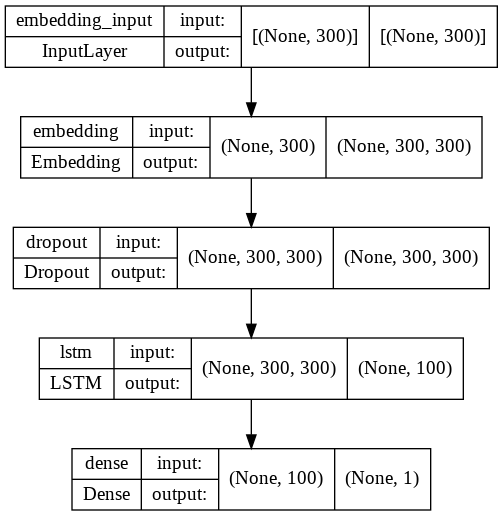

In [48]:
tf.keras.utils.plot_model(model, show_shapes = True)

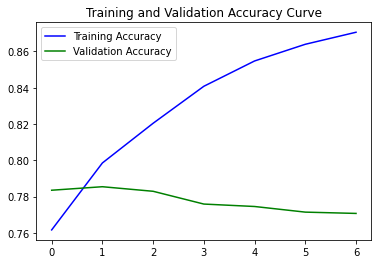

In [57]:
def plot_model_metrics(hist):
  accuracy = hist.history['accuracy']
  val_accuracy =  hist.history['val_accuracy']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'blue', label = 'Training Accuracy')
  plt.plot(epochs, val_accuracy, 'green', label = 'Validation Accuracy')
  plt.title( 'Training and Validation Accuracy Curve')
  plt.legend()

plot_model_metrics(hist = hist)

In [142]:
#preprocessing x_test
def preprocess_test_data(text):

  text = text.apply(lambda x : remove_links(x))
  text = text.apply(lambda x: remove_spcl_chars(x))
  text = text.apply(lambda x: remove_stopwords(x))
  return text

df_test.tweet = preprocess_test_data(df_test.tweet)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.tweet), maxlen = 300)

In [143]:
y_test = np.array(df_test.target_label).reshape(-1,1)


In [144]:
eval = model.evaluate(x_test, np.array(y_test), batch_size = 16)

32/32 [==============================] - 5s 162ms/step - loss: -1.4205 - accuracy: 0.2771


In [121]:
y_pred = []
y_test = list(df_test.target_label)
scores = model.predict(x_test, verbose=1, batch_size=32)
y_pred = [(score) for score in scores]
y_pred = np.argmax(y_pred, axis=-1)

16/16 [==============================] - 2s 126ms/step


In [131]:
def evaluate(sample_text, max_seq_len = 300):
  sample_text = pad_sequences(tokenizer.texts_to_sequences([sample_text]), maxlen = max_seq_len)
  y_pred = model.predict([sample_text])[0]
  if y_pred < 0.4:
    return {'label is ' : 'Negative', 'score ' : float(y_pred)}
  else:
    return {'label is ' : 'Positive', 'score ' : float(y_pred)}
 
   


In [134]:
sample_text0 = 'My bike was put on hold...should have known that.... argh total bummer'

sample_label0 = evaluate(sample_text = sample_text0)
print(sample_label0)

{'label is ': 'Negative', 'score ': 0.007998709566891193}


In [135]:
sample_text1 = 'I Love apple'

sample_label1 = evaluate(sample_text = sample_text1)
print(sample_label1)

{'label is ': 'Positive', 'score ': 0.7717432379722595}


In [136]:
sample_text2 = 'I was so excited to meet Sachin!!!'

sample_label2 = evaluate(sample_text = sample_text2)
print(sample_label2)

{'label is ': 'Positive', 'score ': 0.9568187594413757}
